In [ ]:
!pip install eli5

     |████████████████████████████████| 112kB 5.7MB/s 


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import eli5
from eli5.sklearn import PermutationImportance
from collections import Counter
import missingno as msno
from collections import defaultdict

import csv
import warnings
warnings.filterwarnings('ignore')
import plotly
sns.set_style('darkgrid')

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/My Drive/Fifa 19/data.csv', index_col = False)


In [ ]:
df.shape

(18207, 89)

Cleaning data


Remove unnecessary columns

In [ ]:
df.drop(['Unnamed: 0','ID', 'Photo','Flag','Club Logo','Body Type', 'Real Face'],axis=1,inplace=True)


Checking values

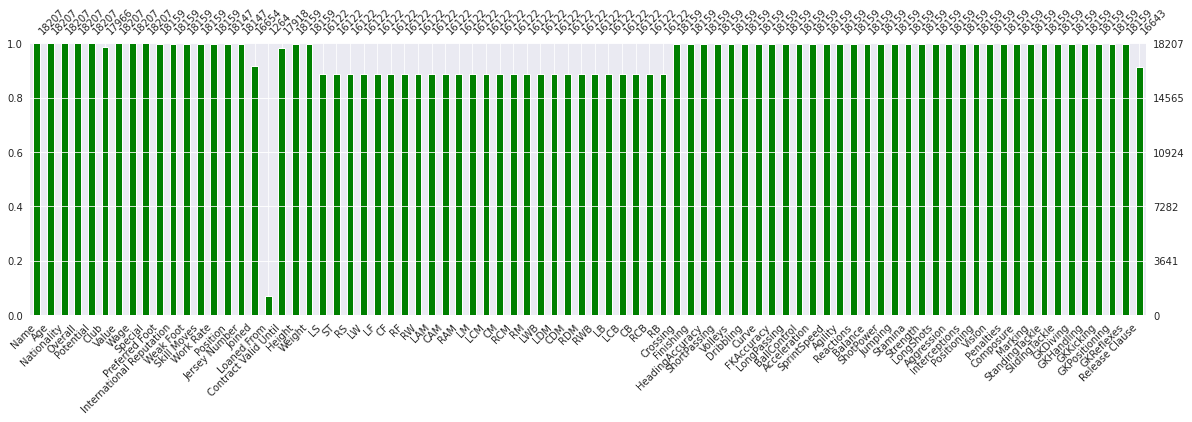

In [ ]:
msno.bar(df,(20,5),color='green', labels=True, fontsize= 10)


Delete players whose position is null, cause they have very little information

In [ ]:
d = df.copy()
pos_nl = d[d['Position'].isnull()].index.tolist()
print ('Number of null positions: ', len(pos_nl))
d.drop(d.index[pos_nl],inplace= True)
pos_nl = d[d['Position'].isnull()].index.tolist()
print ('After dropping null values: ', len(pos_nl))

Number of null positions:  60
After dropping null values:  0


Remaining null columns:

In [ ]:
pd.options.display.max_columns = None

obj= d.isnull().sum()
for key,value in obj.iteritems():
    if value !=0:
      print(key,",",value)

Club , 229
Joined , 1493
Loaned From , 16883
Contract Valid Until , 229
LS , 2025
ST , 2025
RS , 2025
LW , 2025
LF , 2025
CF , 2025
RF , 2025
RW , 2025
LAM , 2025
CAM , 2025
RAM , 2025
LM , 2025
LCM , 2025
CM , 2025
RCM , 2025
RM , 2025
LWB , 2025
LDM , 2025
CDM , 2025
RDM , 2025
RWB , 2025
LB , 2025
LCB , 2025
CB , 2025
RCB , 2025
RB , 2025
Release Clause , 1504


Inspecting Null club players

In [ ]:
cols = ['Wage', 'Value', 'Release Clause', 'Joined','Loaned From','Contract Valid Until' ]
for col in cols:
  print('set for ', col)
  print( set(d[d['Club'].isnull()][col]))

set for  Wage
{'€0'}
set for  Value
{'€0'}
set for  Release Clause
{nan}
set for  Joined
{nan}
set for  Loaned From
{nan}
set for  Contract Valid Until
{nan}


After inspecting null club players, we can colude that these players are free agent players, that's why their  wages and values are 0. They also don't have any join date, contract expiration date or release clause. So, we will convert the null club players to free agents.  

Replace null values of Club, Contract Valid Until, Joined, Loaned From

Remove date from Joined, Contract Valid Until. keep only year portion

In [ ]:
d['Club'].fillna('Free Agent', inplace= True)
d['Loaned From'].fillna('None', inplace= True)
cols= ['Joined', 'Contract Valid Until']
sep = ','
for col in cols:
  d[col].fillna(-1, inplace= True)
  d[col]= d[col].astype(str)
  d[col] = [word.split(sep, 2)[1] if len(word.split(sep, 2))==2 else word for word in d[col]]
  d[col]= d[col].astype(int)


Inspecting null values for attribute range: LS to RB

In [ ]:
cols = d.loc[:,'LS':'RB'].keys().tolist()
for col in cols:
  col_nl = set(d[d[col].isnull()]['Position'])
  print('Position for which ', col, 'is null: ', col_nl)  


Position for which  LS is null:  {'GK'}
Position for which  ST is null:  {'GK'}
Position for which  RS is null:  {'GK'}
Position for which  LW is null:  {'GK'}
Position for which  LF is null:  {'GK'}
Position for which  CF is null:  {'GK'}
Position for which  RF is null:  {'GK'}
Position for which  RW is null:  {'GK'}
Position for which  LAM is null:  {'GK'}
Position for which  CAM is null:  {'GK'}
Position for which  RAM is null:  {'GK'}
Position for which  LM is null:  {'GK'}
Position for which  LCM is null:  {'GK'}
Position for which  CM is null:  {'GK'}
Position for which  RCM is null:  {'GK'}
Position for which  RM is null:  {'GK'}
Position for which  LWB is null:  {'GK'}
Position for which  LDM is null:  {'GK'}
Position for which  CDM is null:  {'GK'}
Position for which  RDM is null:  {'GK'}
Position for which  RWB is null:  {'GK'}
Position for which  LB is null:  {'GK'}
Position for which  LCB is null:  {'GK'}
Position for which  CB is null:  {'GK'}
Position for which  RCB is nu

Removing +... part from LS to RB columns

In [ ]:
sep = '+'
for col in cols:
  d[col].fillna(0,inplace = True)
  d[col]= d[col].astype(str)
  d[col] = [word.split(sep, 1)[0] for word in d[col]]
  d[col]= d[col].astype(float)

Function to convert Height(ft) into Height(inches)

In [ ]:
def parse_ht(ht):
    # format: 7'0.0"
    ht_ = ht.split("'")
    ft_ = float(ht_[0])
    in_ = float(ht_[1].replace("\"",""))
    return (12*ft_) + in_

Convert the following columns from string into numbers

In [ ]:
d['Release Clause'].fillna(-1,inplace = True)
cols= ['Wage', 'Value', 'Release Clause']
for col in cols:
  d[col]= d[col].astype(str)
  d[col] = d[col].str.replace('€', '',1)
  d[col] = (d[col].str.replace(r'[KM]+$', '', regex=True).astype(float) * df[col].str.extract(r'[\d\.]+([KM]+)', expand=False).fillna(1).replace(['K','M'], [10**3, 10**6]).astype(int))
  d[col]= d[col].astype(float)
d['Weight'] = d['Weight'].str.replace('lbs', '',1).astype(float)


#d['Height'] = d['Height'].astype(float)
d['Height'] = d["Height"].apply(lambda x:parse_ht(x))


In [ ]:
d['Jersey Number'] = d['Jersey Number'].astype(int)
for col in d.select_dtypes(include='object').keys().tolist():
  d[col] = d[col].astype(str)

In [ ]:
d.info()

split work rate into two columns - Attacking work rate and Defensive work rate

In [ ]:
d[['Attack Work Rate', 'Defense Work Rate']] = d['Work Rate'].str.split('/', 1, expand=True)
d.drop(['Work Rate'],axis=1,inplace=True)
set(d['Defense Work Rate'])

{' High', ' Low', ' Medium'}

In [ ]:
for col in d.select_dtypes(include='object').keys().tolist():
  print (col, ': ', len(set(d[col])))

Name :  17140
Nationality :  164
Club :  652
Preferred Foot :  2
Position :  27
Loaned From :  342
Attack Work Rate :  3
Defense Work Rate :  3


Convert the following columns to category

In [ ]:
cat_columns = ['Preferred Foot', 'Position', 'Attack Work Rate', 'Defense Work Rate' ]
for col in cat_columns:
  d[col] = d[col].astype('category')
d[cat_columns] = d[cat_columns].apply(lambda x: x.cat.codes)

In [ ]:
d

,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause,Attack Work Rate,Defense Work Rate
0,31,Argentina,94,94,FC Barcelona,110500000.0,565000.0,2202,0,5.0,4.0,4.0,21,10,2004,None,2021,67.0,159.0,88.0,88.0,88.0,92.0,93.0,93.0,93.0,92.0,93.0,93.0,93.0,91.0,84.0,84.0,84.0,91.0,64.0,61.0,61.0,61.0,64.0,59.0,47.0,47.0,47.0,59.0,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,226500000.0,2,2
1,33,Portugal,94,94,Juventus,77000000.0,405000.0,2228,1,5.0,4.0,5.0,26,7,2018,None,2022,74.0,183.0,91.0,91.0,91.0,89.0,90.0,90.0,90.0,89.0,88.0,88.0,88.0,88.0,81.0,81.0,81.0,88.0,65.0,61.0,61.0,61.0,65.0,61.0,53.0,53.0,53.0,61.0,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,127100000.0,0,1
2,26,Brazil,92,93,Paris Saint-Germain,118500000.0,290000.0,2143,1,5.0,5.0,5.0,14,10,2017,None,2022,69.0,150.0,84.0,84.0,84.0,89.0,89.0,89.0,89.0,89.0,89.0,89.0,89.0,88.0,81.0,81.0,81.0,88.0,65.0,60.0,60.0,60.0,65.0,60.0,47.0,47.0,47.0,60.0,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,228100000.0,0,2
3,27,Spain,91,93,Manchester United,72000000.0,260000.0,1471,1,4.0,3.0,1.0,5,1,2011,None,2020,76.0,168.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,138600000.0,2,2
4,27,Belgium,91,92,Manchester City,102000000.0,355000.0,2281,1,4.0,5.0,4.0,19,7,2015,None,2023,71.0,154.0,82.0,82.0,82.0,87.0,87.0,87.0,87.0,87.0,88.0,88.0,88.0,88.0,87.0,87.0,87.0,88.0,77.0,77.0,77.0,77.0,77.0,73.0,66.0,66.0,66.0,73.0,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,196400000.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18202,19,England,47,65,Crewe Alexandra,60000.0,1000.0,1307,1,1.0,2.0,2.0,4,22,2017,None,2019,69.0,134.0,42.0,42.0,42.0,44.0,44.0,44.0,44.0,44.0,45.0,45.0,45.0,44.0,45.0,45.0,45.0,44.0,44.0,45.0,45.0,45.0,44.0,45.0,45.0,45.0,45.0,45.0,34.0,38.0,40.0,49.0,25.0,42.0,30.0,34.0,45.0,43.0,54.0,57.0,60.0,49.0,76.0,43.0,55.0,40.0,47.0,38.0,46.0,46.0,39.0,52.0,43.0,45.0,40.0,48.0,47.0,10.0,13.0,7.0,8.0,9.0,143000.0,2,2
18203,19,Sweden,47,63,Trelleborgs FF,60000.0,1000.0,1098,1,1.0,2.0,2.0,26,21,2018,None,2020,75.0,170.0,45.0,45.0,45.0,39.0,42.0,42.0,42.0,39.0,40.0,40.0,40.0,38.0,35.0,35.0,35.0,38.0,30.0,31.0,31.0,31.0,30.0,29.0,32.0,32.0,32.0,29.0,23.0,52.0,52.0,43.0,36.0,39.0,32.0,20.0,25.0,40.0,41.0,39.0,38.0,40.0,52.0,41.0,47.0,43.0,67.0,42.0,47.0,16.0,46.0,33.0,43.0,42.0,22.0,15.0,19.0,10.0,9.0,9.0,5.0,12.0,113000.0,2,2
18204,16,England,47,67,Cambridge United,60000.0,1000.0,1189,1,1.0,3.0,2

In [ ]:
d.to_csv('/content/drive/My Drive/Fifa 19/clean-data-2.csv', index = False)

In [ ]:

from bs4 import BeautifulSoup

soup = BeautifulSoup(open('/content/drive/My Drive/Fifa 19/club_rankings.html'), "html.parser")

In [ ]:

table = soup.find("table", attrs={"class":"t1"})


In [ ]:
# The first tr contains the field names.
headings= ['rank', 'position_change', 'club', 'country', '11/12', '12/13', '13/14', '14/15', '15/16', '16/17', '17/18', '18/19', '19/20', '20/21', 'TitlePoints', 'CountryPart', 'TotalPoints']

csv_file = open('/content/drive/My Drive/Fifa 19/club_rank.csv', 'w')  
writer = csv.DictWriter(csv_file, fieldnames=headings)
writer.writeheader()
datasets = []
for row in table.find_all("tr")[1:]:
    d1 =  [td.get_text() for td in row.find_all("th")]
    d2 = [td.get_text() for td in row.find_all("td")]
    d = d2 + d1

    datasets.append(d)
    dct ={}
    for  i, h in enumerate(headings):
      dct[h] = d[i]
    print (dct)
    writer.writerow(dct)
for dataset in datasets:
  print (dataset)

In [ ]:
csv_file.close()

In [ ]:
cdf = (set(df['Club']))
ccr = set(cr['club'])
common = list(set(ccr).intersection((cdf)))

In [ ]:
ccr=  [i.lower() for i in ccr]
ccr

In [ ]:
len(cdf)

652

In [ ]:
len(common)

120

In [ ]:
common = list(common)